In [2]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import torchvision


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Number of train images: 960
Number of val images: 192
Number of test images: 300
[{'boxes': tensor([[1431., 1326., 1562., 1509.]]), 'labels': tensor([21]), 'image_id': tensor([1043]), 'area': tensor([17732.5000])}]


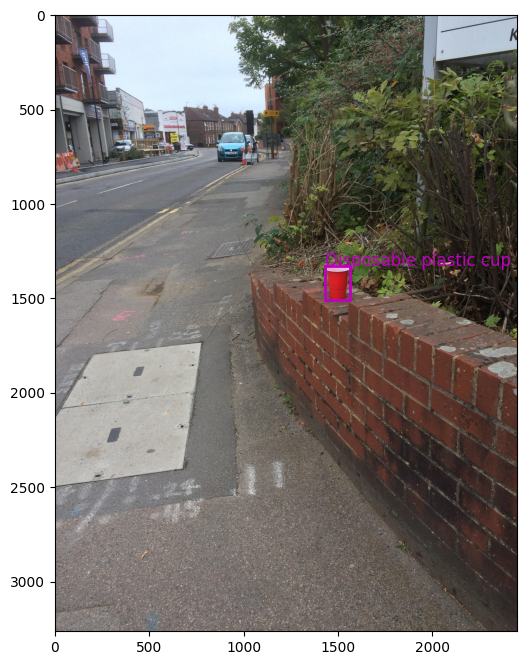

In [3]:
class TacoDataset(torch.utils.data.Dataset):
    def __init__(self, datatype="train"):
        self.datatype = datatype
        self.root = '/mnt/c/Users/frede/Downloads/data_wastedetection/'
        self.anns_file_path = os.path.join(self.root, 'annotations.json')
        self.coco = COCO(self.anns_file_path)
        self.ids = list(sorted(self.coco.imgs.keys()))

        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])

        self.category_id_to_name = {
            d["id"]: d["name"] for d in self.coco.dataset["categories"]
        }

        idxs = np.arange(len(self.ids))
        idxs = np.random.permutation(idxs)
        self.train_idxs = idxs[:int(0.8 * len(idxs))]
        self.test_idxs = idxs[int(0.8 * len(idxs)):]
        self.train_idxs = self.train_idxs[:int(0.8 * len(self.train_idxs))]
        self.val_idxs = self.train_idxs[int(0.8 * len(self.train_idxs)):]

        print(f"Number of train images: {len(self.train_idxs)}")
        print(f"Number of val images: {len(self.val_idxs)}")
        print(f"Number of test images: {len(self.test_idxs)}")

    def __getitem__(self, idx):
        if self.datatype == "train":
            idx = self.train_idxs[idx]
        elif self.datatype == "val":
            idx = self.val_idxs[idx]
        elif self.datatype == "test":
            idx = self.test_idxs[idx]

        coco = self.coco
        img_id = self.ids[idx]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path))

        num_objs = len(coco_annotation)

        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = []
        for i in range(num_objs):
            labels.append(coco_annotation[i]['category_id'])
        labels = torch.as_tensor(labels, dtype=torch.int64)

        img_id = torch.tensor([img_id])

        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        if self.datatype == "train":
            return len(self.train_idxs)
        elif self.datatype == "val":
            return len(self.val_idxs)
        elif self.datatype == "test":
            return len(self.test_idxs)

def get_dataloader(dataset):
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_batch_size = 1

    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              num_workers=4,
                                              collate_fn=collate_fn)

    return data_loader

def show_img(img, annotations, label_dict, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    img = img.cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)

    ax.imshow(img)

    for idx in range(len(annotations["boxes"])):
        box = annotations["boxes"][idx].cpu()
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='m', facecolor='none')
        ax.add_patch(rect)

        label_id = annotations["labels"][idx].cpu()
        label = label_dict[label_id.item()]
        ax.text(xmin, ymin, f"{label}", fontsize=12, color="m")

if __name__ == "__main__":
    dataset = TacoDataset()
    data_loader = get_dataloader(dataset)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        print(annotations)

        show_img(imgs[0], annotations[0], dataset.category_id_to_name)
        plt.savefig("test.png")

        break

In [4]:
tacoData = TacoDataset()

# collate_fn is something we need for the batch..
def collate_fn(batch):
    return tuple(zip(*batch))


batchSize = 1
num_classes = 60

dataloader = torch.utils.data.DataLoader(tacoData, batch_size=batchSize, shuffle=True, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Number of train images: 960
Number of val images: 192
Number of test images: 300


In [5]:
# Define model

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


/home/peetz/miniconda3/envs/02514/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/peetz/miniconda3/envs/02514/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
def show_img(img, annotations, predictions, label_dict, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    img = img.cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)

    ax.imshow(img)

    for idx in range(len(annotations["boxes"])):
        box = annotations["boxes"][idx].cpu()
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='m', facecolor='none')
        ax.add_patch(rect)

        label_id = annotations["labels"][idx].cpu()
        label = label_dict[label_id.item()]
        ax.text(xmin, ymin, f"{label}", fontsize=12, color="m")

In [7]:
def visualize_results(images, targets, predictions, label_dict):
    num_images = len(images)
    
    for i in range(num_images):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = np.clip(img, 0, 1)
        
        target_boxes = targets[i]["boxes"].cpu()
        target_labels = targets[i]["labels"].cpu()
        
        pred_boxes = predictions[i]["boxes"].cpu()
        pred_labels = predictions[i]["labels"].cpu()
        pred_scores = predictions[i]["scores"].cpu()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img)
        
        # # Plot target boxes
        # for j in range(len(target_boxes)):
            # box = target_boxes[j]
            # label = label_dict[target_labels[j].item()]
            
            # rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='g', facecolor='none')
            # ax.add_patch(rect)
            # ax.text(box[0], box[1], f"{label}", fontsize=8, color="g")
        
        # Plot predicted boxes
        for j in range(len(pred_boxes)):
            box = pred_boxes[j]
            label = label_dict[pred_labels[j].item()]
            score = pred_scores[j].item()
            
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(box[0], box[1], f"{label}: {score:.2f}", fontsize=12, color="r")

        plt.show()

In [12]:
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    i = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len(data_loader)}, Loss: {losses}')

         

Iteration: 1/960, Loss: 2.606947660446167
[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


AttributeError: 'list' object has no attribute 'values'